# Similarity tests

the goal of this notebook is to explore more in depth a solution that:
* store a dataset of images
* explore further similarity metrics
* explore dimensionality reduction 

### Packages

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt

import cv2

import os
import random

import shutil
import glob

In [2]:
from datasets import load_dataset
from transformers import AutoFeatureExtractor, AutoModel

import torchvision.transforms as T
import torch 

In [3]:
from tqdm.auto import tqdm

In [48]:
import mlflow
from  mlflow.tracking import MlflowClient

In [4]:
pd.set_option('display.max_colwidth', None)

### Configs

In [5]:
my_local_path = os.path.normpath(os.getcwd() + os.sep + os.pardir)

In [6]:
# configs for the train/test dataset
n_train_images = 200
seed_data = 123

In [7]:
# model credential
model_ckpt = 'google/vit-base-patch16-224-in21k'

In [8]:
# configs for the embeddig matrix
num_samples = 190
seed = 42

In [ ]:
tmp_path = my_local_path + '/research_env/tmp_image/'

### Transformations

In [9]:
csv_path = my_local_path + "/extract_data/data-interview-clean.csv"

In [10]:
image_id = pd.read_csv(csv_path,sep = ',', error_bad_lines=False)

C:\Users\Miguel\AppData\Local\Temp\ipykernel_8380\3703840460.py:1: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  image_id = pd.read_csv(csv_path,sep = ',', error_bad_lines=False)


In [11]:
image_id.head(5)

url      id  \
0   https://farm6.staticflickr.com/3016/2814480856_58f6012cc0_o.jpg   88162   
1           https://c1.staticflickr.com/1/1/359504_987ba125a3_o.jpg  163796   
2  https://farm2.staticflickr.com/8750/16779609830_1669a8aea3_o.jpg  136467   
3  https://farm2.staticflickr.com/8698/17006894309_1e9959405e_o.jpg  687954   
4   https://farm2.staticflickr.com/5333/9220842670_df40013b65_o.jpg  125510   

                        jpgName  
0   2814480856_58f6012cc0_o.jpg  
1       359504_987ba125a3_o.jpg  
2  16779609830_1669a8aea3_o.jpg  
3  17006894309_1e9959405e_o.jpg  
4   9220842670_df40013b65_o.jpg

image shape explo

In [12]:
data_ = {
    "jpgName":list(),
    "ax0":list(),
    "ax1":list(),
    "ax2":list(),
}

for jpg in image_id.jpgName.values:

    imgt = cv2.imread(my_local_path + '/images/' + jpg)
    x_shape = imgt.shape
    data_['jpgName'].append(jpg)
    data_['ax0'].append(x_shape[0])
    data_['ax1'].append(x_shape[1])
    data_['ax2'].append(x_shape[2])

data_ = pd.DataFrame(data_)

In [13]:
data_.describe()

ax0          ax1    ax2
count   295.000000   295.000000  295.0
mean    967.976271  1141.501695    3.0
std     558.866031   684.320493    0.0
min     202.000000   300.000000    3.0
25%     600.000000   640.000000    3.0
50%     768.000000   960.000000    3.0
75%    1202.000000  1432.500000    3.0
max    3456.000000  4471.000000    3.0

* about 75% are encapsulated in  a matrix 600x600x3 or higher
* min image matrix size is 200x300x3
* reducing to 100x100x3 will impact 100% of the images
* some images with rectangular shape

* seems to be a good option to take a sample of images 400x400x3

### testing Transformer (encoder) - model using embedings

<b> 1. dataset

In [26]:
orders = list(range(len(image_id)))
random.seed(seed_data)
random.shuffle(orders)

image_id['order'] = orders
image_id['type'] = np.where(image_id.order <= n_train_images, 'train', 'test')

image_id = image_id.drop(columns = ['order'])

In [27]:
image_id.head()

url      id  \
0   https://farm6.staticflickr.com/3016/2814480856_58f6012cc0_o.jpg   88162   
1           https://c1.staticflickr.com/1/1/359504_987ba125a3_o.jpg  163796   
2  https://farm2.staticflickr.com/8750/16779609830_1669a8aea3_o.jpg  136467   
3  https://farm2.staticflickr.com/8698/17006894309_1e9959405e_o.jpg  687954   
4   https://farm2.staticflickr.com/5333/9220842670_df40013b65_o.jpg  125510   

                        jpgName   type  
0   2814480856_58f6012cc0_o.jpg  train  
1       359504_987ba125a3_o.jpg  train  
2  16779609830_1669a8aea3_o.jpg   test  
3  17006894309_1e9959405e_o.jpg   test  
4   9220842670_df40013b65_o.jpg  train

In [28]:
for i in range(len(image_id)):
    row = image_id.iloc[i]
    jpgName = row.jpgName
    typex = row.type
    
    src = my_local_path + '/images/' + jpgName
    dst = my_local_path + f'/dataset/{typex}/' + jpgName
    
    if not os.path.exists(my_local_path + f'/dataset/{typex}/'):
        os.makedirs(my_local_path + f'/dataset/{typex}/')
    
    shutil.copyfile(src, dst)

metadata

In [29]:
def create_metadata(data,type_x):
    tmp = data[data.type == type_x][['jpgName','id','url']]
    tmp['file_name'] = tmp.jpgName
    tmp = tmp[['file_name','jpgName','id','url']]
    tmp.to_csv(my_local_path + f'/dataset/{type_x}/' + 'metadata.csv', index = False, header = True )
    return print(f'save {type_x}')

In [30]:
create_metadata(image_id,'train')
create_metadata(image_id,'test')

save train
save test


<b> load data

In [12]:
image_path = my_local_path + '/dataset'
dataset = load_dataset("imagefolder", data_dir=image_path, drop_labels=True)

Resolving data files:   0%|          | 0/202 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/95 [00:00<?, ?it/s]

Found cached dataset imagefolder (C:/Users/Miguel/.cache/huggingface/datasets/imagefolder/default-6a4a94ef6efc9e5a/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f)


  0%|          | 0/2 [00:00<?, ?it/s]

In [13]:
dataset['train']

Dataset({
    features: ['image', 'jpgName', 'id', 'url'],
    num_rows: 201
})

In [14]:
dataset['train'][1]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=640x640>,
 'jpgName': '10218081326_565699acb7_o.jpg',
 'id': 176701,
 'url': 'https://c1.staticflickr.com/9/8413/10218081326_565699acb7_o.jpg'}

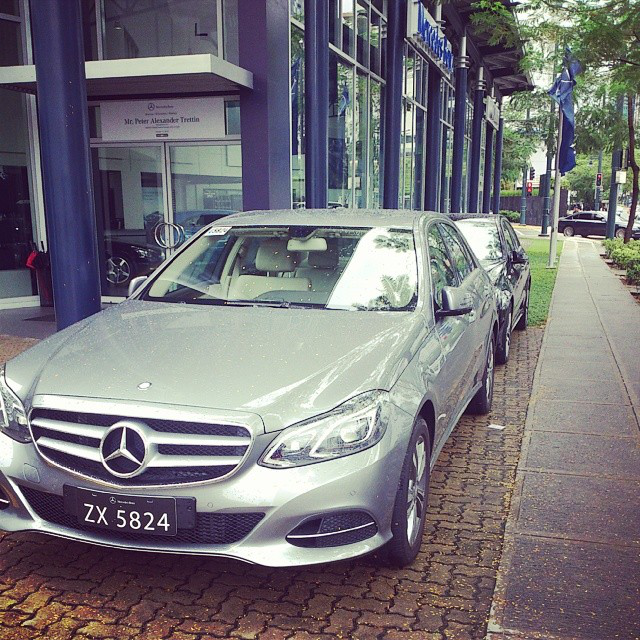

In [15]:
dataset['train'][1]['image']

dataset done

<b> 2. model

In [16]:
extractor = AutoFeatureExtractor.from_pretrained(model_ckpt)
model = AutoModel.from_pretrained(model_ckpt)

C:\Users\Miguel\anaconda3\lib\site-packages\transformers\models\vit\feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [59]:
# Data transformation chain.
transformation_chain = T.Compose(
    [
        # We first resize the input image to 256x256 and then we take center crop.
        T.Resize(int((224 / 224) * extractor.size["height"])),
        T.CenterCrop(extractor.size["height"]),
        T.ToTensor(),
        T.Normalize(mean=extractor.image_mean, std=extractor.image_std),
    ]
)

In [19]:
def extract_embeddings(model: torch.nn.Module):
    """Utility to compute embeddings."""
    device = model.device

    def pp(batch):
        images = batch["image"]
        # `transformation_chain` is a compostion of preprocessing
        # transformations we apply to the input images to prepare them
        # for the model. For more details, check out the accompanying Colab Notebook.
        image_batch_transformed = torch.stack(
            [transformation_chain(image) for image in images]
        )
        new_batch = {"pixel_values": image_batch_transformed.to(device)}
        with torch.no_grad():
            embeddings = model(**new_batch).last_hidden_state[:, 0].cpu()
        return {"embeddings": embeddings}

    return pp

In [20]:
candidate_subset = dataset["train"].shuffle(seed=seed).select(range(num_samples))

Loading cached shuffled indices for dataset at C:\Users\Miguel\.cache\huggingface\datasets\imagefolder\default-6a4a94ef6efc9e5a\0.0.0\37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f\cache-05bcd43241bf9f3f.arrow


In [21]:
device = "cuda" if torch.cuda.is_available() else "cpu"
extract_fn = extract_embeddings(model.to(device))
candidate_subset_emb = candidate_subset.map(extract_fn, batched=True, batch_size=24)

Loading cached processed dataset at C:\Users\Miguel\.cache\huggingface\datasets\imagefolder\default-6a4a94ef6efc9e5a\0.0.0\37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f\cache-c0a613f855de0252.arrow


In [22]:
candidate_subset_emb

Dataset({
    features: ['image', 'jpgName', 'id', 'url', 'embeddings'],
    num_rows: 190
})

In [23]:
candidate_ids = []

for id in tqdm(range(len(candidate_subset_emb))):
    id_true = candidate_subset_emb[id]["id"]

    # Create a unique indentifier.
    entry = str(id) + "_" + str(id_true)

    candidate_ids.append(entry)

  0%|          | 0/190 [00:00<?, ?it/s]

In [24]:
all_candidate_embeddings = np.array(candidate_subset_emb["embeddings"])
all_candidate_embeddings = torch.from_numpy(all_candidate_embeddings)

In [25]:
def compute_scores(emb_one, emb_two):
    """Computes cosine similarity between two vectors."""
    scores = torch.nn.functional.cosine_similarity(emb_one, emb_two)
    return scores.numpy().tolist()


def fetch_similar(model, all_candidate_embeddings, image, top_k=5):
    """Fetches the `top_k` similar images with `image` as the query."""
    # Prepare the input query image for embedding computation.
    image_transformed = transformation_chain(image).unsqueeze(0)
    new_batch = {"pixel_values": image_transformed.to(device)}

    # Comute the embedding.
    with torch.no_grad():
        query_embeddings = model(**new_batch).last_hidden_state[:, 0].cpu()

    # Compute similarity scores with all the candidate images at one go.
    # We also create a mapping between the candidate image identifiers
    # and their similarity scores with the query image.
    sim_scores = compute_scores(all_candidate_embeddings, query_embeddings)
    similarity_mapping = dict(zip(candidate_ids, sim_scores))
 
    # Sort the mapping dictionary and return `top_k` candidates.
    similarity_mapping_sorted = dict(
        sorted(similarity_mapping.items(), key=lambda x: x[1], reverse=True)
    )
    id_entries = list(similarity_mapping_sorted.keys())[:top_k]

    ids = list(map(lambda x: int(x.split("_")[0]), id_entries))
    ids_true = list(map(lambda x: int(x.split("_")[-1]), id_entries))
    scores = list(similarity_mapping_sorted.values())[:top_k]
    
    return ids, ids_true, scores, similarity_mapping_sorted

In [26]:
#test_idx = np.random.choice(len(dataset["test"]))  ## good ids 72, 38, 17
test_idx = 38
test_sample = dataset["test"][test_idx]["image"]

sim_ids, sim_ids_true, sim_score, sim_map = fetch_similar(model, all_candidate_embeddings,test_sample)
print(f'test id is: {test_idx}')
print(f"top 5 ids are: {sim_ids}")
print(f"top 5 actual ids are: {sim_ids_true}")
print(f"top 5 scores are: {sim_score}")

test id is: 38
top 5 ids are: [6, 80, 44, 20, 111]
top 5 actual ids are: [423485, 106187, 579115, 117201, 195166]
top 5 scores are: [0.6933450088041885, 0.6407462925440754, 0.5778804254596666, 0.4826035706874567, 0.44418710175889053]


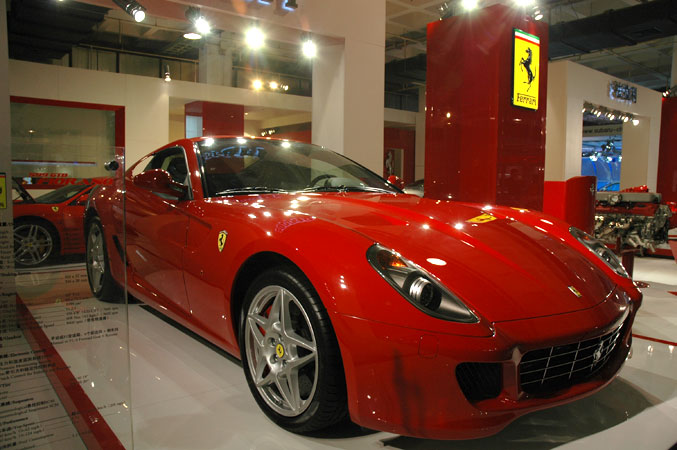

In [27]:
dataset["test"][test_idx]["image"]

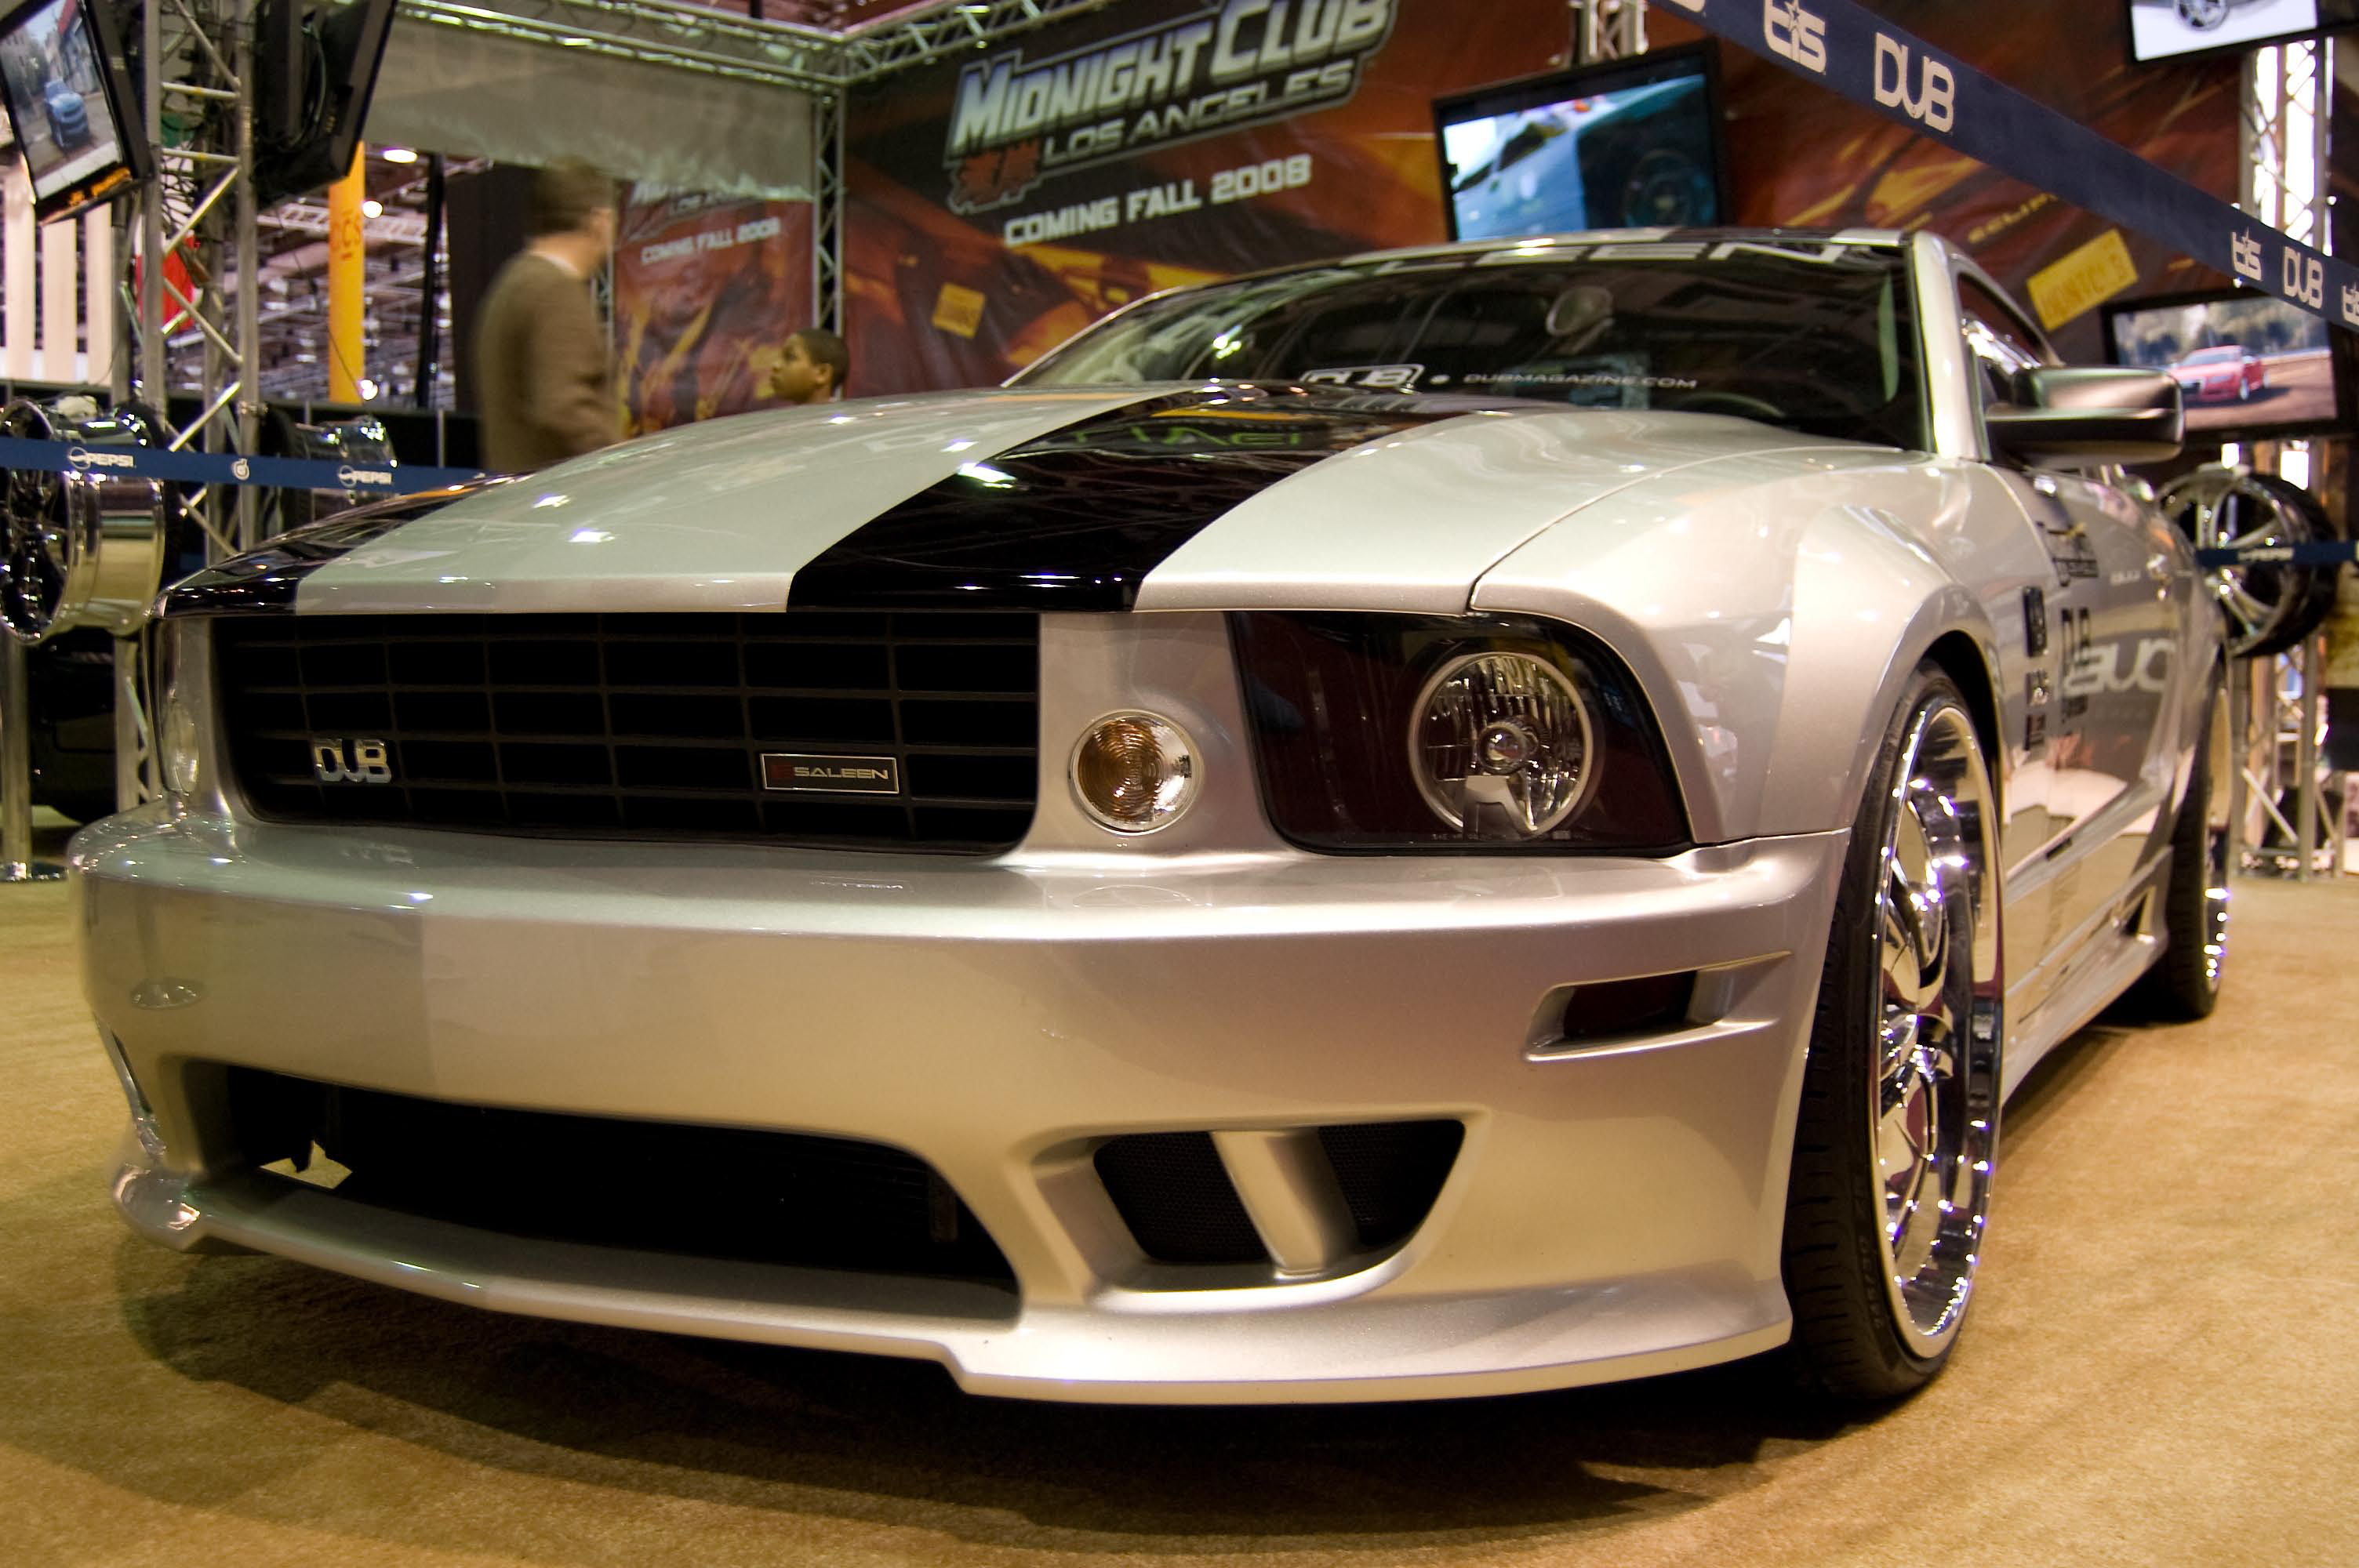

In [28]:
candidate_subset_emb[sim_ids[0]]["image"]

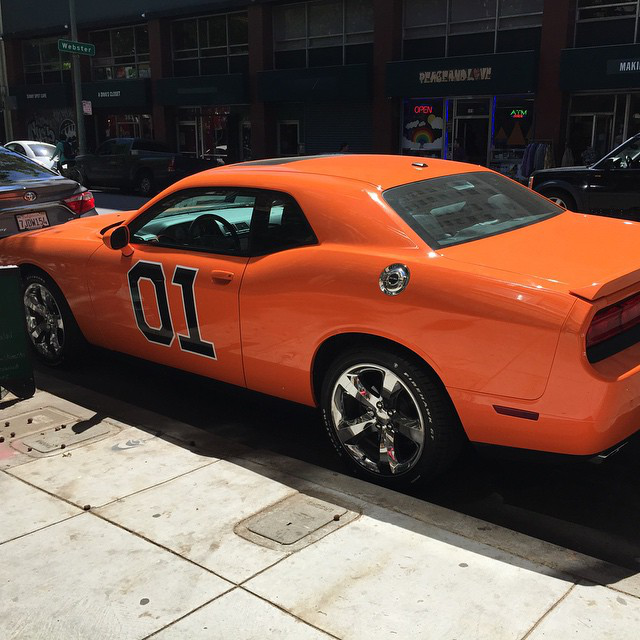

In [29]:
candidate_subset_emb[sim_ids[1]]["image"]

In [30]:
candidate_subset_emb['id'][0:10]

[627569, 306835, 107621, 260940, 531707, 156945, 423485, 95880, 43296, 319545]

In [31]:
candidate_subset_emb[4]['embeddings'][0:5]

[-0.28340640664100647,
 0.1850126087665558,
 -0.35367000102996826,
 -0.023930363357067108,
 -0.2129320651292801]

In [32]:
all_candidate_embeddings.shape

torch.Size([190, 768])

In [33]:
all_candidate_embeddings[4][0:5]

tensor([-0.2834,  0.1850, -0.3537, -0.0239, -0.2129], dtype=torch.float64)

candidate embedding order is the order of the all embeddings

to save it as a model save the tensor and the candidates ids in the respective order to create a matrix-model

In [34]:
#all_candidate_embeddings, candidate_subset_emb['id']

some points up to here:
* good results using embedding
    * use of big percentage of the data
    * data stored in vectors
    * fast execution - no need of for loop
    * avoid the use of resize of the images because it is done in the model
* solution is given as a matrix operation

testing using external_image

In [47]:
tmp_image_name = '303217440_f595f9b310_o.jpg'
test_id_path = my_local_path + '/dataset/test/' + tmp_image_name

if not os.path.exists(tmp_path):
        os.makedirs(tmp_path)
        
dst = tmp_path + tmp_image_name
shutil.copyfile(test_id_path, dst)

tmp_dataset = load_dataset("imagefolder", data_dir=tmp_path, drop_labels=True)

tmp_image = tmp_dataset['train'][0]['image']

sim_ids, sim_ids_true, sim_score, sim_map = fetch_similar(model, all_candidate_embeddings,tmp_image)
print(f'test id is: {test_idx}')
print(f"top 5 ids are: {sim_ids}")
print(f"top 5 actual ids are: {sim_ids_true}")
print(f"top 5 scores are: {sim_score}")

shutil.rmtree(tmp_path)

Extracting data files: 0it [00:00, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset imagefolder downloaded and prepared to C:/Users/Miguel/.cache/huggingface/datasets/imagefolder/default-a4854d84b6a6f266/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

test id is: 38
top 5 ids are: [6, 80, 44, 20, 111]
top 5 actual ids are: [423485, 106187, 579115, 117201, 195166]
top 5 scores are: [0.6933450088041885, 0.6407462925440754, 0.5778804254596666, 0.4826035706874567, 0.44418710175889053]


<b> Saving model and labels

In [60]:
extractor

ViTFeatureExtractor {
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTFeatureExtractor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

In [61]:
extractor_dict = {
    "size": extractor.size,
    "image_mean":extractor.image_mean,
    "image_std":extractor.image_std,
}

In [65]:
# Data transformation chain.
transformation_chain = T.Compose(
    [
        # We first resize the input image to 256x256 and then we take center crop.
        T.Resize(int((224 / 224) * extractor_dict['size']["height"])),
        T.CenterCrop(extractor_dict['size']["height"]),
        T.ToTensor(),
        T.Normalize(mean=extractor_dict["image_mean"], std=extractor_dict['image_std']),
    ]
)

In [66]:
proj_name = 'ImageFinder'

In [67]:
registered_model_name = f'{proj_name}_models' 

In [68]:
mlflow.log_dict(extractor_dict, "extractor_dict.json")

In [69]:
mlflow.pytorch.log_model(
    model, 
    artifact_path=f"{proj_name}-run",
    registered_model_name = registered_model_name,
)

C:\Users\Miguel\anaconda3\lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
Registered model 'ImageFinder_models' already exists. Creating a new version of this model...
2023/04/30 12:10:36 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: ImageFinder_models, version 2
Created version '2' of model 'ImageFinder_models'.


In [70]:
emb_true_id = torch.from_numpy(np.array(candidate_subset_emb['id']))

In [71]:
all_candidate_embeddings

tensor([[-0.2441, -0.2220, -0.0473,  ..., -0.1652, -0.1527,  0.0220],
        [-0.2045,  0.0259, -0.0803,  ...,  0.0761, -0.1106,  0.1948],
        [ 0.1377, -0.0513, -0.0444,  ..., -0.3763, -0.0135,  0.1053],
        ...,
        [ 0.1478, -0.1942,  0.1271,  ..., -0.1187, -0.1130,  0.0970],
        [-0.0328,  0.0290,  0.3066,  ...,  0.0052, -0.0654,  0.1390],
        [ 0.0244, -0.0770, -0.1249,  ..., -0.0613,  0.1288,  0.2515]],
       dtype=torch.float64)

In [72]:
## embeding_db is an object where the last element of row is the id

embeding_db = torch.cat((all_candidate_embeddings, emb_true_id.unsqueeze(1)), 1)

In [73]:
torch.save(embeding_db, 'embeding_db.pt')

<b> Loading Model and embeddings

In [90]:
uri = 'runs:/1f30b69e008e42c795b551e3fb240884'

In [93]:
extractor_dict = mlflow.artifacts.load_dict(
    uri+'/extractor_dict.json'
)

In [94]:
model_local_path = mlflow.artifacts.download_artifacts(
            run_id= '1f30b69e008e42c795b551e3fb240884',
            artifact_path=f"{proj_name}-run"
        )   

In [95]:
model = mlflow.pytorch.load_model(model_local_path)

In [99]:
embeding_db = torch.load('embeding_db.pt')

In [100]:
embeddings_loaded = embeding_db[:,0:-1]
ids_loaded = embeding_db[:,-1]

In [101]:
# Data transformation chain.
transformation_chain = T.Compose(
    [
        # We first resize the input image to 256x256 and then we take center crop.
        T.Resize(int((224 / 224) * extractor_dict["size"]["height"])),
        T.CenterCrop(extractor_dict["size"]["height"]),
        T.ToTensor(),
        T.Normalize(mean=extractor_dict["image_mean"], std=extractor_dict["image_std"]),
    ]
)

In [102]:
def compute_scores(emb_one, emb_two):
    """Computes cosine similarity between two vectors."""
    scores = torch.nn.functional.cosine_similarity(emb_one, emb_two)
    return scores.numpy().tolist()


def fetch_similar(image, top_k=5):
    """Fetches the `top_k` similar images with `image` as the query."""
    # Prepare the input query image for embedding computation.
    image_transformed = transformation_chain(image).unsqueeze(0)
    new_batch = {"pixel_values": image_transformed.to(device)}

    # Comute the embedding.
    with torch.no_grad():
        query_embeddings = model(**new_batch).last_hidden_state[:, 0].cpu()

    # Compute similarity scores with all the candidate images at one go.
    # We also create a mapping between the candidate image identifiers
    # and their similarity scores with the query image.
    sim_scores = compute_scores(embeddings_loaded, query_embeddings)
    similarity_mapping = dict(zip(candidate_ids, sim_scores))
 
    # Sort the mapping dictionary and return `top_k` candidates.
    similarity_mapping_sorted = dict(
        sorted(similarity_mapping.items(), key=lambda x: x[1], reverse=True)
    )
    id_entries = list(similarity_mapping_sorted.keys())[:top_k]

    ids = list(map(lambda x: int(x.split("_")[0]), id_entries))
    ids_true = list(map(lambda x: int(x.split("_")[-1]), id_entries))
    scores = list(similarity_mapping_sorted.values())[:top_k]
    
    return ids, ids_true, scores, similarity_mapping_sorted

In [103]:
#test_idx = np.random.choice(len(dataset["test"]))  ## good ids 72, 38, 17
test_idx = 38
test_sample = dataset["test"][test_idx]["image"]

sim_ids, sim_ids_true, sim_score, sim_map = fetch_similar(test_sample)
print(f'test id is: {test_idx}')
print(f"top 5 ids are: {sim_ids}")
print(f"top 5 actual ids are: {sim_ids_true}")
print(f"top 5 scores are: {sim_score}")

test id is: 38
top 5 ids are: [6, 80, 44, 20, 111]
top 5 actual ids are: [423485, 106187, 579115, 117201, 195166]
top 5 scores are: [0.6933450088041885, 0.6407462925440754, 0.5778804254596666, 0.4826035706874567, 0.44418710175889053]
